## 1. Data Preparation

### 1.1 Loading Dependencies

In [16]:
#import libraries
import pandas as pd #untuk dataframe
import matplotlib.pyplot as plt  #untuk visualisasi
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report # evaluate metrics
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer # TF-IDF
from sklearn.model_selection import train_test_split # split data
from sklearn.svm import LinearSVC # model untuk data mining
from imblearn.over_sampling import SMOTE # handling imbalance

In [17]:
# read and show data
df = pd.read_excel("product_reviews_dirty.xlsx",index_col=0) # read data
df.head(3) # show top data

,text,rating,category,product_name,product_id,sold,shop_id,product_url,sentimen
1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...,Positif
2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,Positif
3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,Positif


In [18]:
df.shape

(40607, 9)

### 1.2 exploratory data analysis

In [19]:
# show sentimen data
df.sentimen.value_counts()

Positif    39574
Negatif      996
Netral        36
Name: sentimen, dtype: int64

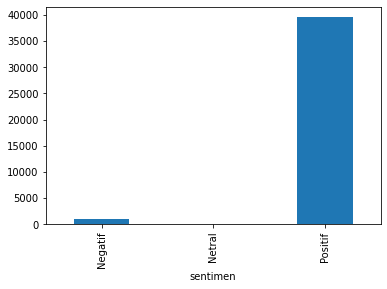

In [20]:
# visualize
df.groupby('sentimen')['text'].count().plot.bar() 
plt.show()

The data is imbalanced-> data over-sampling

## 2. Data Preprocessing

### 2.1 Duplicate value checking

In [21]:
df.duplicated().sum()

0

### 2.2 Missing value checking

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40607 entries, 1 to 40893
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          40602 non-null  object
 1   rating        40607 non-null  int64 
 2   category      40607 non-null  object
 3   product_name  40607 non-null  object
 4   product_id    40607 non-null  int64 
 5   sold          40593 non-null  object
 6   shop_id       40607 non-null  int64 
 7   product_url   40607 non-null  object
 8   sentimen      40606 non-null  object
dtypes: int64(3), object(6)
memory usage: 3.1+ MB


In [23]:
#check missing value
df.isna().sum()

text             5
rating           0
category         0
product_name     0
product_id       0
sold            14
shop_id          0
product_url      0
sentimen         1
dtype: int64

In [24]:
df.dropna(inplace=True)

print(f'Missing Value:\n{df.isna().sum()}')
print('\nDataFrame shape:',df.shape) # (row, column)

Missing Value:
text            0
rating          0
category        0
product_name    0
product_id      0
sold            0
shop_id         0
product_url     0
sentimen        0
dtype: int64

DataFrame shape: (40587, 9)


In [25]:
df.columns

Index(['text', 'rating', 'category', 'product_name', 'product_id', 'sold',
       'shop_id', 'product_url', 'sentimen'],
      dtype='object')

### 2.3 Feature Selection

In [26]:
#drop some data
df.drop(columns=df.columns[1:8], axis=1, inplace=True) # columns[nilai_awal : nilai_akhir+1], axis=1 => column | axis=0 => row

#encoding process
df['sentimen_encoded'] = df['sentimen'].astype('category').cat.codes

#print sample of the encoded-data
df.sample()

,text,sentimen,sentimen_encoded
11636,Sudah diterima. Trims.,Positif,2


## 3. Data Modeling

### 3.1. Training Phase

In [27]:
X = df['text'].astype('str')
y = df['sentimen'].astype('str')

In [28]:
# initialization TF-IDF

# vectorize the 'text' data
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)

# transform vectorized data into 'tf-idf' value
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [29]:
# for handling imbalance dataset, use SMOTE
smote = SMOTE(random_state=1, k_neighbors=5)

# over sampling process
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

In [30]:
# split data into independent variable (X) and dependent variable (y) - hold-out
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

In [31]:
# training phase started
svc = LinearSVC().fit(X_train, y_train) # kernel, C, gamma

### 3.2 Evaluating Phase

In [32]:
# predicting phase started
y_pred = svc.predict(X_test)

In [33]:
# show metrics's score
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Negatif       0.91      0.98      0.94     11890
      Netral       0.99      1.00      1.00     11815
     Positif       0.98      0.90      0.94     11895

    accuracy                           0.96     35600
   macro avg       0.96      0.96      0.96     35600
weighted avg       0.96      0.96      0.96     35600



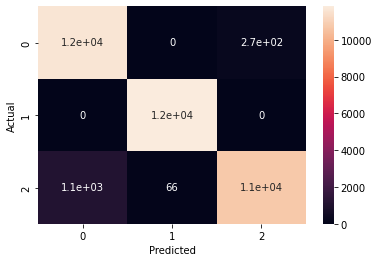

In [34]:
# visualize confusion matrix
matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(matrix, annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.show()

In [35]:
confusion_matrix(y_test, y_pred)

array([[11619,     0,   271],
       [    0, 11815,     0],
       [ 1087,    66, 10742]])

### 3.3 Data Testing

In [36]:
print(svc.predict(count_vect.transform(['Barang saya buang'])))

['Negatif']


In [37]:
print(svc.predict(count_vect.transform(['Barang saya beli lagi ya'])))

['Positif']
